# Antecedentes

Imports variables globales y clases auxiliares.

## Imports

Bibliotecas a utilizar

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

import sklearn
from sklearn.svm import SVR, OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

## Auxiliares

Se definen clases y funciones auxiliares que nos van a servir más adelante.

In [48]:
# clase que nos dice si hay elementos afuera del dominio de aplicación usando
# el método de leverage
class LeverageMethod(sklearn.base.BaseEstimator):
    def fit(self, x, y=None):
        self.normal_mat = np.linalg.inv(x.T @ x)
        self.n_samples = x.shape[0]
        self.n_features = x.shape[1]
        return self

    def decision_function(self, x):
        leverages = np.diagonal(x @ self.normal_mat @ x.T)
        leverages = self.threshold_ - leverages
        return leverages

    def predict(self, x):
        leverages = self.decision_function(x)
        preds = np.where(leverages < 0, -1, 1)
        return preds

    @property
    def threshold_(self):
        return 3*self.n_features/self.n_samples

In [49]:
# función que regresa el nombre de un stimador de sklearn
# model: el modelo a extraer el nombre
# returns: el nombre del modelo
def mname(model):
    return model.__class__.__name__

In [50]:
# función que regresa el validation score
# model: el modelo de sklearn a evaluar
# x: datos de entrada
# y: salida esperada
# metrics: la metrica (o metricas en una lista) para evaluar
def score_cv(model, x, y, metrics="r2"):
    res = sklearn.model_selection.cross_validate(
        pipeline, x_train, y, scoring=metrics, cv=CV_SPLITTER, n_jobs=-1
    )

    if isinstance(metrics, str):
        return np.mean(res["test_score"])
    return {metric: np.mean(res[f"test_{metric}"]) for metric in metrics}

## Globales

Variables globales a usar

In [51]:
# semilla para cosas random
RANDOM_STATE = 5712492
# minima varianza a conservar en las features
MIN_VARIANCE = 0

# agoritmo de escalamiento
# (StandardScaler, MinMaxScaler o Normalizer)
SCALER = StandardScaler()

# primer selector/transformador de features
# (SelectFromModel o SelectKBest)
feat_selector_model = RandomForestRegressor(n_estimators=650, #650 es bueníimo
                                             #criterion='squared_error', #criterion{“squared_error”, “absolute_error”, “poisson”}, default=”squared_error”
                                             max_depth=50,
                                             #min_samples_split=9, #default=2
                                             min_samples_leaf=8,
                                             #min_weight_fraction_leaf=0.4,
                                             #max_features=100,
                                             #max_leaf_nodes=1000,
                                             min_impurity_decrease=1E-6,
                                             #bootstrap=False,
                                             #oob_score=False,
                                             #n_jobs=None,
                                             random_state=RANDOM_STATE,
                                             #verbose=0,
                                             warm_start=True,
                                             #ccp_alpha=0.0,
                                             #max_samples=None
                                            )
FEAT_SELECTOR1 = SelectFromModel(feat_selector_model, max_features=70)

# segundo selector/transformador de features
# (Genetic o PCA)
n_feats_desired = 14
FEAT_SELECTOR2 = PCA(n_components=n_feats_desired, random_state=RANDOM_STATE)

# algoritmo de regresión final
REGRESSOR = SVR(cache_size=1000, max_iter=100000, C=2.0)

# algoritmos de dominio de aplicación
APP_DOMAINS = [
    LeverageMethod(),
    OneClassSVM(nu=0.01, gamma=0.1)
]

# metricas a usar como evaluación
METRICS = ["r2", "neg_mean_squared_error"]

# splitter de cross validation
CV_SPLITTER = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# numero de y scrambles
N_SCRAMBLES = 4 #En el paper son 150

# Cargar datos

Descargar datos de la nube y leerlos en un DataFrame y `x, y`.

In [52]:
# descargamos data
! gdown --id 1Pl90HjkxdulEKhlYdLNWsOxN1BKKJTyv
! gdown --id 1gi1zAHjlEziF3C21Tq8fCTFpZdcST34s

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Pl90HjkxdulEKhlYdLNWsOxN1BKKJTyv
To: /content/nlz_activity.csv
100% 964/964 [00:00<00:00, 2.44MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gi1zAHjlEziF3C21Tq8fCTFpZdcST34s
To: /content/nlz_data.csv
100% 2.01M/2.01M [00:00<00:00, 14.8MB/s]


In [53]:
# cargamos data
df_x = pd.read_csv("nlz_data.csv")
df_x = df_x.iloc[:, 1:]  # quitar "No."
df_x = df_x.select_dtypes("number")  # quitar non_numeric
df_y = pd.read_csv("nlz_activity.csv")

df_data = df_x.assign(Activity=df_y)
df_data

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,Activity
0,426.89,8.712041,32.9867,50.1089,33.7899,55.0964,0.673198,1.022631,0.689590,1.124416,...,1.000000,1.0,0.8,0.5,1.0,1,0.900000,0.166667,1.000,5.316053
1,456.92,8.621132,35.2283,54.3198,36.0058,59.7210,0.664685,1.024902,0.679355,1.126811,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.148742
2,426.90,8.712245,32.7879,50.1016,33.5854,55.4684,0.669141,1.022482,0.685416,1.132008,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,1.000,5.504456
3,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.167491
4,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,5.271646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,422.48,7.971321,34.4008,53.9961,35.1479,59.7770,0.649072,1.018794,0.663168,1.127868,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.333333,1.000,5.920819
70,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,5.301030
71,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,0.833333,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,4.853872
72,496.01,8.131311,39.5885,61.8615,41.0798,68.8403,0.648992,1.014123,0.673439,1.128530,...,0.666667,1.0,0.8,0.5,1.0,1,0.852381,0.166667,0.750,4.756962


In [54]:
# dividimos train test con stratified
discretizer = sklearn.preprocessing.KBinsDiscretizer(
  n_bins=10, encode="ordinal", strategy="uniform"
)
splitter = StratifiedShuffleSplit(test_size=0.25, random_state=RANDOM_STATE)
y_discrete = discretizer.fit_transform(df_y.values)
split, split_test = next(splitter.split(df_x.values, y_discrete))

fractions = ["train" if i in split else "test" for i in range(df_data.shape[0])]
df_data = df_data.assign(fraction=fractions)
df_data

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,Activity,fraction
0,426.89,8.712041,32.9867,50.1089,33.7899,55.0964,0.673198,1.022631,0.689590,1.124416,...,1.0,0.8,0.5,1.0,1,0.900000,0.166667,1.000,5.316053,test
1,456.92,8.621132,35.2283,54.3198,36.0058,59.7210,0.664685,1.024902,0.679355,1.126811,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.148742,train
2,426.90,8.712245,32.7879,50.1016,33.5854,55.4684,0.669141,1.022482,0.685416,1.132008,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,1.000,5.504456,train
3,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,6.167491,train
4,456.93,8.621321,35.0295,54.3125,35.8013,60.0930,0.660934,1.024764,0.675496,1.133830,...,1.0,0.8,0.5,1.0,1,0.852381,0.333333,1.000,5.271646,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,422.48,7.971321,34.4008,53.9961,35.1479,59.7770,0.649072,1.018794,0.663168,1.127868,...,1.0,0.8,0.5,1.0,1,0.876190,0.333333,1.000,5.920819,train
70,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,5.301030,test
71,461.33,9.414898,33.8142,50.4326,34.6478,55.0404,0.690086,1.029237,0.707098,1.123273,...,1.0,0.8,0.5,1.0,1,0.876190,0.166667,0.875,4.853872,train
72,496.01,8.131311,39.5885,61.8615,41.0798,68.8403,0.648992,1.014123,0.673439,1.128530,...,1.0,0.8,0.5,1.0,1,0.852381,0.166667,0.750,4.756962,train


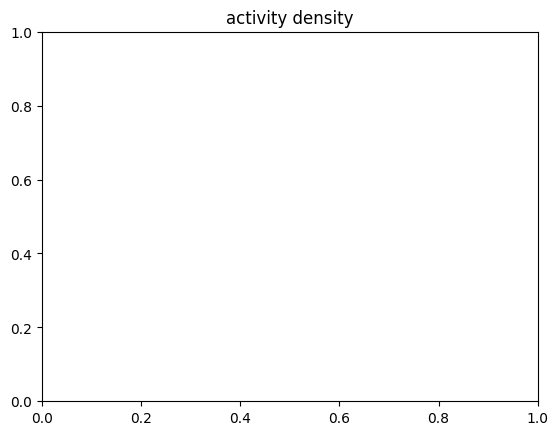

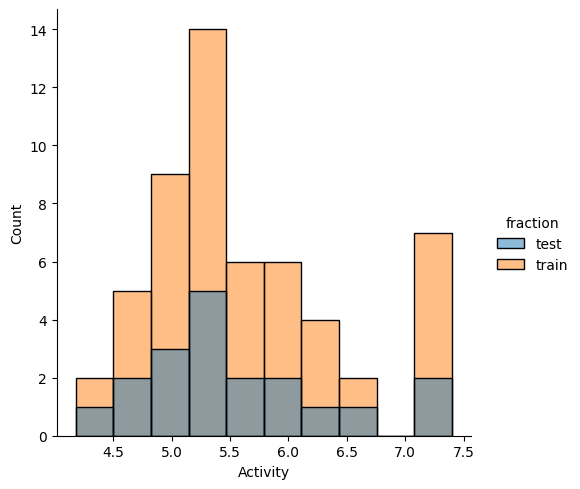

In [55]:
# algunas cuantas visualizaciones

plt.title("activity density")
sns.displot(data=df_data, x="Activity", hue="fraction", alpha=0.5, bins=10)
plt.show()

In [56]:
# sacamos los vectores (x, y) de interés
x_train = df_x[df_data["fraction"] == "train"].values
y_train = df_y[df_data["fraction"] == "train"].values
x_test = df_x[df_data["fraction"] == "test"].values
y_test = df_y[df_data["fraction"] == "test"].values
y_train = np.reshape(y_train, -1)
y_test = np.reshape(y_test, -1)

x_train = x_train.astype(float)
y_train = y_train.astype(float)
x_test = x_test.astype(float)
y_test = y_test.astype(float)

x_train

array([[4.56920000e+02, 8.62113208e+00, 3.52283000e+01, ...,
        8.52380952e-01, 3.33333333e-01, 1.00000000e+00],
       [4.26900000e+02, 8.71224490e+00, 3.27879000e+01, ...,
        8.76190476e-01, 1.66666667e-01, 1.00000000e+00],
       [4.56930000e+02, 8.62132075e+00, 3.50295000e+01, ...,
        8.52380952e-01, 3.33333333e-01, 1.00000000e+00],
       ...,
       [4.61330000e+02, 9.41489796e+00, 3.38142000e+01, ...,
        8.76190476e-01, 1.66666667e-01, 8.75000000e-01],
       [4.96010000e+02, 8.13131148e+00, 3.95885000e+01, ...,
        8.52380952e-01, 1.66666667e-01, 7.50000000e-01],
       [4.26890000e+02, 8.71204082e+00, 3.29867000e+01, ...,
        9.00000000e-01, 1.66666667e-01, 1.00000000e+00]])

# Entrenamiento

Se crea el modelo final final y se entrena

In [57]:
# creamos pipeline: el modelo final final
steps = [
    ("var0", VarianceThreshold(MIN_VARIANCE)),
    ("scaling", SCALER),
    ("feat_selector1", FEAT_SELECTOR1),
    ("feat_selector2", FEAT_SELECTOR2),
    ("regressor", REGRESSOR)
]
pipeline = Pipeline(steps, verbose=True)
pipeline = pipeline.fit(x_train, y_train)
pipeline.set_params(verbose=False)
pipeline

[Pipeline] .............. (step 1 of 5) Processing var0, total=   0.0s
[Pipeline] ........... (step 2 of 5) Processing scaling, total=   0.0s
[Pipeline] .... (step 3 of 5) Processing feat_selector1, total=   9.1s
[Pipeline] .... (step 4 of 5) Processing feat_selector2, total=   0.0s
[Pipeline] ......... (step 5 of 5) Processing regressor, total=   0.0s


Pipeline(steps=[('var0', VarianceThreshold(threshold=0)),
                ('scaling', StandardScaler()),
                ('feat_selector1',
                 SelectFromModel(estimator=RandomForestRegressor(max_depth=50,
                                                                 min_impurity_decrease=1e-06,
                                                                 min_samples_leaf=8,
                                                                 n_estimators=650,
                                                                 random_state=5712492,
                                                                 warm_start=True),
                                 max_features=70)),
                ('feat_selector2', PCA(n_components=14, random_state=5712492)),
                ('regressor', SVR(C=2.0, cache_size=1000, max_iter=100000))])

# Validación

Se extraen los resultados y gráficas finales a reportar

## Resumen

In [58]:
# Regresa un dataframe con datos generales de un entrenamiento completo
# metric: la metrica a usar para evaluar
def validate_summary(metric):
    scorer = sklearn.metrics.get_scorer(metric)
    df = pd.DataFrame(index=[metric], data={
        "train": scorer(pipeline, x_train, y_train),
        "test": scorer(pipeline, x_test, y_test),
        "cv": score_cv(pipeline, x_train, y_train, metrics=metric)
    })
    return df

In [59]:
df = pd.DataFrame()
for metric in tqdm(METRICS, desc="Summary"):
    df_ = validate_summary(metric)
    df = pd.concat([df, df_]) # Use pd.concat to combine DataFrames
df

Summary:   0%|          | 0/2 [00:00<?, ?it/s]

,train,test,cv
r2,0.930487,0.561792,0.562655
neg_mean_squared_error,-0.044585,-0.280160,-0.227306


## Dominio de aplicación

In [60]:
# grafica residuales vs app_domain_score (leverage)
# model: el modelo de domionio de aplicación a usar (leverage o oneclassSVM)
# returns: el dataframe con los resultados
def validate_domain(model):
    transformer = pipeline[:-1]
    estimator = pipeline[-1]
    df = pd.DataFrame(columns=["Score", "Residual", "fraction"])

    splits = [(x_train, y_train, "train"), (x_test, y_test, "test")]
    for (x, y, fraction) in splits:
        z = transformer.transform(x)
        score = model.decision_function(z)
        res = estimator.predict(z) - y
        df_ = pd.DataFrame({"Score": score, "Residual": res,
                            "fraction": fraction})
        df = pd.concat([df, df_])
        #df.append(df_, ignore_index=True)

    sns.scatterplot(data=df, x="Score", y="Residual", hue="fraction")
    plt.title(f"Redisual vs {mname(model)}")
    plt.axvline(x=0, c="C2")
    plt.show()
    return df

In [61]:
# primero entrena a los modelos de dominio de aplicación
transformer = pipeline[:-1]
for model in APP_DOMAINS:
    z_train = transformer.transform(x_train)
    model = model.fit(z_train)
print("Numero de features después de las reducciones:", z_train.shape[0])
APP_DOMAINS

Numero de features después de las reducciones: 55


[LeverageMethod(), OneClassSVM(gamma=0.1, nu=0.01)]

<ipython-input-60-dc0310f872b4>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_])


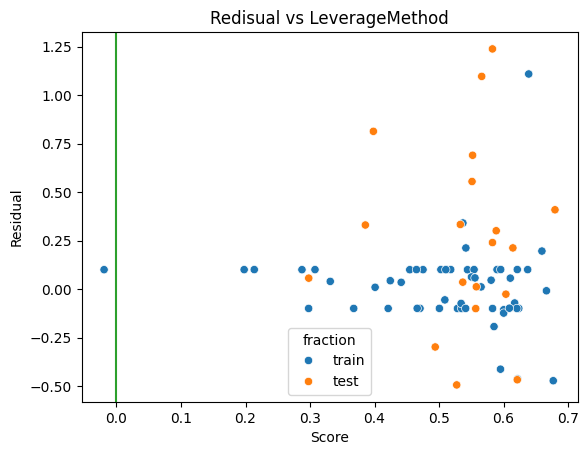

<ipython-input-60-dc0310f872b4>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_])


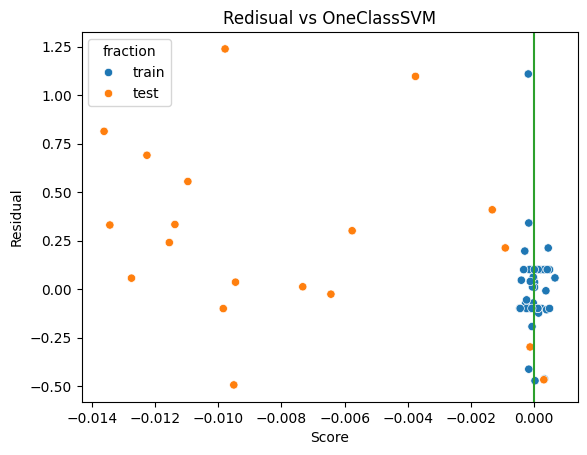

In [62]:
for model in APP_DOMAINS:
    validate_domain(model)

## Y Scramble

In [63]:
# hace un plot con los resultados del y scramble
# returns: el dataframe con la información
def validate_yscramble():
    df = pd.DataFrame()

    # data sin shuffle
    scores = score_cv(model, x_train, y_train, metrics=METRICS)
    info = {**scores, "scrambled": False, "Frecuency": 0}
    df = pd.concat([df, pd.DataFrame([info])]) # Convert 'info' to a DataFrame before concatenating

    # data con shuffle
    for rep in trange(N_SCRAMBLES, desc="Scrambling"):
        y = sklearn.utils.shuffle(y_train)
        scores = score_cv(pipeline, x_train, y, metrics=METRICS)
        info = {**scores, "scrambled": True, "Frecuency": rep + 1}
        df = pd.concat([df, pd.DataFrame([info])]) # Convert 'info' to a DataFrame before concatenating

    df = df.melt(id_vars=["Frecuency", "scrambled"], value_vars=METRICS,
                 var_name="metric", value_name="q2")

    # plot
    for metric in METRICS:
        df_ = df.loc[df["metric"] == metric]
        sns.scatterplot(data=df_, x="Frecuency", y="q2", hue="scrambled")
        plt.title(f"Y-Scramble {metric}")
        plt.show()
    return df

Scrambling:   0%|          | 0/4 [00:00<?, ?it/s]

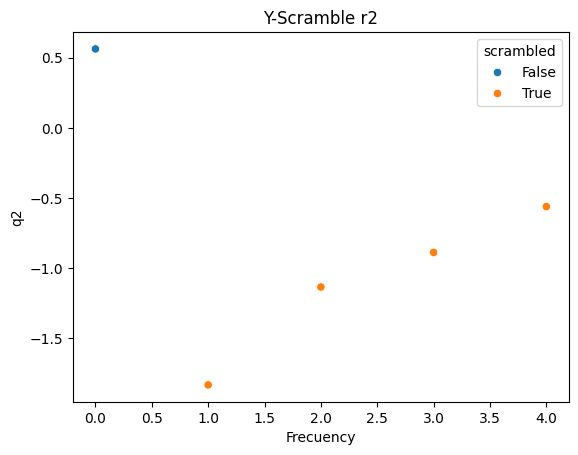

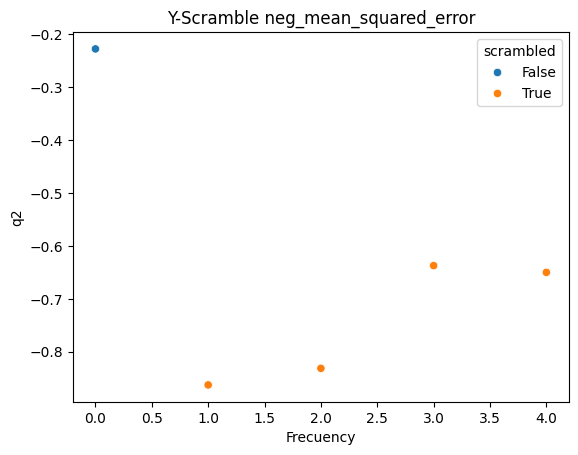

,Frecuency,scrambled,metric,q2
0,0,False,r2,0.562655
1,1,True,r2,-1.832927
2,2,True,r2,-1.134664
3,3,True,r2,-0.888211
4,4,True,r2,-0.561464
5,0,False,neg_mean_squared_error,-0.227306
6,1,True,neg_mean_squared_error,-0.862791
7,2,True,neg_mean_squared_error,-0.831418
8,3,True,neg_mean_squared_error,-0.637151
9,4,True,neg_mean_squared_error,-0.649912


In [64]:
validate_yscramble()

In [65]:
pd.DataFrame(df_)

,train,test,cv
neg_mean_squared_error,-0.044585,-0.28016,-0.227306


## True vs Pred

In [66]:
def validate_true_vs_pred():
    df = pd.DataFrame(columns=["Experimental", "Predicted", "fraction"])
    splits = [(x_train, y_train, "train"), (x_test, y_test, "test")]
    for (x, y, fraction) in splits:
        yhat = pipeline.predict(x)
        df_ = pd.DataFrame({"Experimental": y, "Predicted": yhat, "fraction": fraction})
        df = pd.concat([df, df_])
        #df = df.append(df_, ignore_index=True)
    sns.scatterplot(data=df, x="Experimental", y="Predicted", hue="fraction")
    plt.title("Experimental vs Predicted")
    plt.plot()
    return df

<ipython-input-66-bb6fa2fa10f8>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_])


,Experimental,Predicted,fraction
0,6.148742,7.257170,train
1,5.504456,5.404187,train
2,6.167491,5.694787,train
3,5.271646,5.467326,train
4,5.251037,5.351117,train
...,...,...,...
14,4.180259,5.417892,test
15,5.537602,5.870405,test
16,7.221849,6.754140,test
17,5.886057,6.125571,test


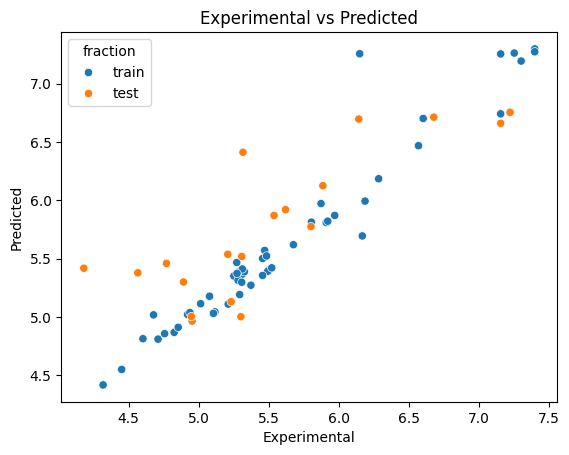

In [67]:
validate_true_vs_pred()

# Test Final

Evaluación final con las nuevas mols

In [68]:
# cargar datos
! gdown --id 1uIyIQSw78mIr371GNkLtVj43fMjqo-bu
df_val = pd.read_csv("explor2_allv.csv")
df_val

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uIyIQSw78mIr371GNkLtVj43fMjqo-bu
To: /content/explor2_allv.csv
100% 1.15M/1.15M [00:00<00:00, 107MB/s]


,mseq,No.,NAME,MW,AMW,Sv,Se,Sp,Si,Mv,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
0,138,1,3RO5,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,...,1,0,0,0,0,0,0,0,0,0
1,139,2,3RO5,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,...,9,4,0,0,0,0,0,0,0,0
2,140,3,3RO5,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,...,4,1,0,0,0,0,0,0,0,0
3,141,4,3RO5,504.91,9.016250,37.5715,58.3090,37.5738,62.9772,0.670920,...,1,0,0,0,0,0,0,0,0,0
4,142,5,3RO5,504.91,9.016250,37.5715,58.3090,37.5738,62.9772,0.670920,...,14,8,4,0,0,0,0,0,0,0
5,143,6,3RO5,456.87,9.323878,33.8895,50.8799,33.9375,55.1000,0.691622,...,0,0,0,0,0,0,0,0,0,0
6,144,7,3RO5,456.87,9.323878,33.8895,50.8799,33.9375,55.1000,0.691622,...,3,0,0,0,0,0,0,0,0,0
7,145,8,3RO5,460.91,8.696415,34.9431,54.6471,35.4603,59.9304,0.659304,...,1,2,0,0,0,0,0,0,0,0
8,146,9,3RO5,430.88,8.793469,32.7015,50.4362,33.2444,55.3058,0.667378,...,1,1,0,0,0,0,0,0,0,0
9,147,10,3RO5,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,...,1,2,0,0,0,0,0,0,0,0


In [69]:
# seleccionar solo las columnas que estaban incluídas en el df inicial
names = df_val["mseq"]
df_val = df_val[df_x.columns]
df_val

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02
0,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,1.035332,0.677530,1.125311,...,1.0,0.666667,1.000000,0.8,0.5,0.833333,0.5,0.757143,0.333333,0.875
1,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,1.035332,0.677530,1.125311,...,1.0,0.666667,1.000000,0.8,0.5,0.833333,0.5,0.757143,0.333333,0.875
2,473.90,8.941509,35.6365,54.8726,35.9091,59.6415,0.672387,1.035332,0.677530,1.125311,...,1.0,0.666667,1.000000,0.8,0.5,0.833333,0.5,0.757143,0.333333,0.875
3,504.91,9.016250,37.5715,58.3090,37.5738,62.9772,0.670920,1.041232,0.670961,1.124593,...,0.5,0.500000,0.500000,0.6,0.0,0.333333,0.0,0.347619,0.333333,0.625
4,504.91,9.016250,37.5715,58.3090,37.5738,62.9772,0.670920,1.041232,0.670961,1.124593,...,0.5,0.500000,0.500000,0.6,0.0,0.333333,0.0,0.347619,0.333333,0.625
5,456.87,9.323878,33.8895,50.8799,33.9375,55.1000,0.691622,1.038365,0.692602,1.124490,...,1.0,0.666667,1.000000,0.4,0.0,1.000000,1.0,0.723810,0.333333,1.000
6,456.87,9.323878,33.8895,50.8799,33.9375,55.1000,0.691622,1.038365,0.692602,1.124490,...,1.0,0.666667,1.000000,0.4,0.0,1.000000,1.0,0.723810,0.333333,1.000
7,460.91,8.696415,34.9431,54.6471,35.4603,59.9304,0.659304,1.031077,0.669062,1.130762,...,1.0,0.666667,0.833333,0.8,0.0,0.833333,0.5,0.661905,0.333333,0.875
8,430.88,8.793469,32.7015,50.4362,33.2444,55.3058,0.667378,1.029310,0.678457,1.128690,...,1.0,0.833333,1.000000,0.6,0.0,1.000000,1.0,0.776190,0.333333,1.000
9,468.93,8.683889,36.2283,55.3198,37.0058,60.7210,0.670894,1.024441,0.685293,1.124463,...,1.0,0.666667,1.000000,0.8,0.5,1.000000,1.0,0.852381,0.166667,0.750


In [70]:
# calcular todo
df = pd.DataFrame({"pred": pipeline.predict(df_val.values)}, index=names)
for model in APP_DOMAINS:
    score = model.decision_function(pipeline[:-1].transform(df_val.values))
    df[f"{mname(model)}_domain"] = score
df

,pred,LeverageMethod_domain,OneClassSVM_domain
mseq,,,
138,5.170462,-0.041043,-0.013961
139,5.157893,-0.104305,-0.013960
140,5.162565,-0.052735,-0.013961
141,5.062563,-0.201398,-0.013969
142,5.095046,-0.277376,-0.013969
143,5.088258,-0.104112,-0.013964
144,5.091069,-0.748596,-0.013969
145,5.568570,0.522547,-0.013739
146,5.129308,0.168511,-0.013966


In [71]:
df.to_excel('explor2_predictions.xlsx', index=False)

In [72]:
from google.colab import files
files.download('explor2_predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

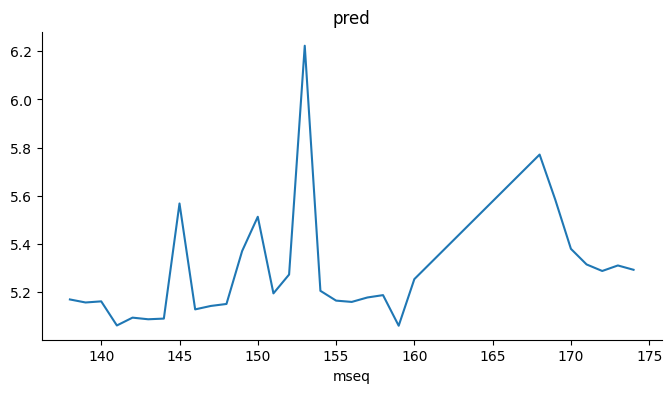

In [73]:
# @title pred

from matplotlib import pyplot as plt
df['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

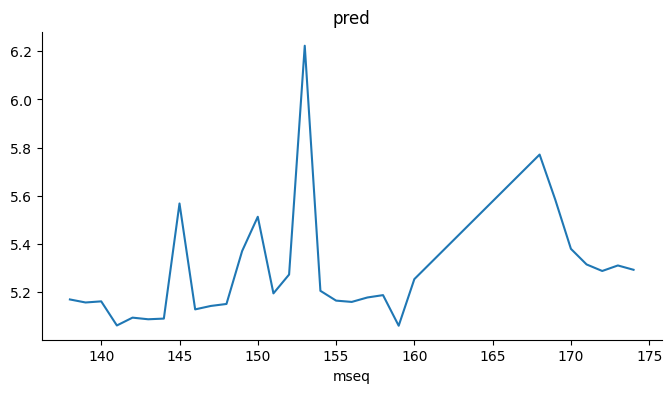

In [74]:
# @title pred

from matplotlib import pyplot as plt
df['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

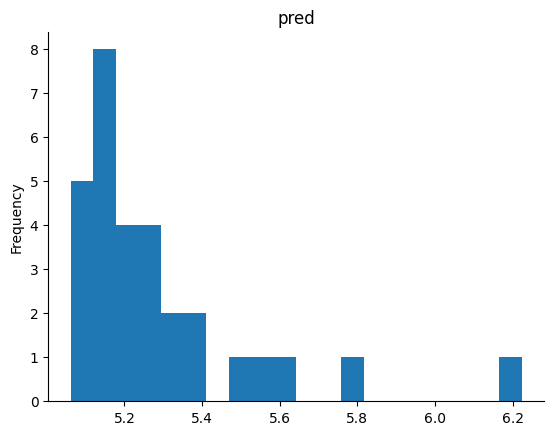

In [75]:
# @title pred

from matplotlib import pyplot as plt
df['pred'].plot(kind='hist', bins=20, title='pred')
plt.gca().spines[['top', 'right',]].set_visible(False)